In [1]:
import os
import os.path
import glob
import pandas as pd
import numpy as np
from PIL import Image
import preprocessing as proc
from pandas.api.types import CategoricalDtype
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

pd.options.display.max_columns = 1000

DATA_PATH = '../datasets/'
TIFF_PATH = '/Users/vladarozova/Dropbox/New experiment/Images/tiff/'

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Load background measurements

In [2]:
bg = pd.DataFrame()

# Load each dataset and add stiffness column
for s in ("0.2", "0.5", "2", "8", "16", "32", "64"):
    tmp = pd.read_csv(DATA_PATH + s + "-B-background.csv", index_col=0)
    tmp['stiffness'] = np.float(s)
    bg = pd.concat([bg, tmp], sort=True)
    
# Reset index
bg.reset_index(inplace=True, drop=True)

# Rename columns
bg.columns = ["channel", "bg_mean", "bg_median", "bg_sdt", "stiffness"]

# Add columns with combination, well, site
bg['combination'] = "B"
bg['well'] = bg.channel.str.split(pat = "-", expand=True)[0]
bg['site'] = bg.channel.str.split(pat = "-", expand=True)[1]

# Add a column with channel
bg['channel'] = bg.channel.str.split(pat = "-", expand=True)[2].str.split(pat = ".", expand=True)[0]

# Add a column with corresponding fluorophore (COMBINATION B !!!)
fluorophores = {'DAPI' : 'DAPI', 'WGA' : 'FITC', 'Vim' : 'AF568', 'Ker' : 'AF647'}
bg['fluorophore'] = bg.channel.map(fluorophores)

# Create label
bg = proc.create_label(bg, per_cell=False)

print(bg.shape)
bg.head()

(292, 10)


,channel,bg_mean,bg_median,bg_sdt,stiffness,combination,well,site,fluorophore,label
0,WGA,268.314,272,52.462,0.2,B,A1,1,FITC,0.2-B-A1-1
1,DAPI,48.874,49,2.755,0.2,B,A1,1,DAPI,0.2-B-A1-1
2,Vim,102.633,101,11.028,0.2,B,A1,1,AF568,0.2-B-A1-1
3,Ker,89.640,87,11.788,0.2,B,A1,1,AF647,0.2-B-A1-1
4,WGA,252.484,245,57.304,0.2,B,A1,2,FITC,0.2-B-A1-2


# Load metadata

In [3]:
# Load metadata
metadata = proc.load_data("Metadata.csv", data_path=DATA_PATH)

# Rename columns to lower case
metadata.rename(str.lower, axis='columns', inplace=True)

# Create label
metadata = proc.create_label(metadata, per_cell=False)

# Add a column with corresponding channel (COMBINATION B!!!)
channels = {'DAPI' : 'DAPI', 'FITC' : 'WGA', 'AF568' : 'Vim', 'AF647' : 'Ker'}
metadata['channel'] = metadata.fluorophore.map(channels)

metadata.head()

,stiffness,combination,well,site,channel,fluorophore,gain,offset,power,attenuation,pcf,zposition,zoffset,user,label
0,0.2,B,A1,1,Ker,AF647,700,0,0.005,0.95,7679.330711,795.356,0.003333,44709390,0.2-B-A1-1
1,0.2,B,A1,1,Vim,AF568,680,0,0.020,0.95,7679.330711,795.356,0.003333,44709390,0.2-B-A1-1
2,0.2,B,A1,1,WGA,FITC,730,0,0.030,0.98,7679.330711,795.356,0.003333,44709390,0.2-B-A1-1
3,0.2,B,A1,1,DAPI,DAPI,550,0,0.024,0.98,7679.330711,795.356,0.003333,44709390,0.2-B-A1-1
4,0.2,B,A1,2,Ker,AF647,700,0,0.005,0.95,7679.330711,795.272,0.003332,44709390,0.2-B-A1-2


# Background signal vs gain

In [4]:
cols = ['label', 'stiffness', 'combination', 'well', 'site', 'channel', 'fluorophore']
df = pd.merge(bg, metadata, on=cols)
print(df.shape)
df.head()

(292, 18)


,channel,bg_mean,bg_median,bg_sdt,stiffness,combination,well,site,fluorophore,label,gain,offset,power,attenuation,pcf,zposition,zoffset,user
0,WGA,268.314,272,52.462,0.2,B,A1,1,FITC,0.2-B-A1-1,730,0,0.030,0.98,7679.330711,795.356,0.003333,44709390
1,DAPI,48.874,49,2.755,0.2,B,A1,1,DAPI,0.2-B-A1-1,550,0,0.024,0.98,7679.330711,795.356,0.003333,44709390
2,Vim,102.633,101,11.028,0.2,B,A1,1,AF568,0.2-B-A1-1,680,0,0.020,0.95,7679.330711,795.356,0.003333,44709390
3,Ker,89.640,87,11.788,0.2,B,A1,1,AF647,0.2-B-A1-1,700,0,0.005,0.95,7679.330711,795.356,0.003333,44709390
4,WGA,252.484,245,57.304,0.2,B,A1,2,FITC,0.2-B-A1-2,730,0,0.030,0.98,7679.330711,795.272,0.003332,44709390


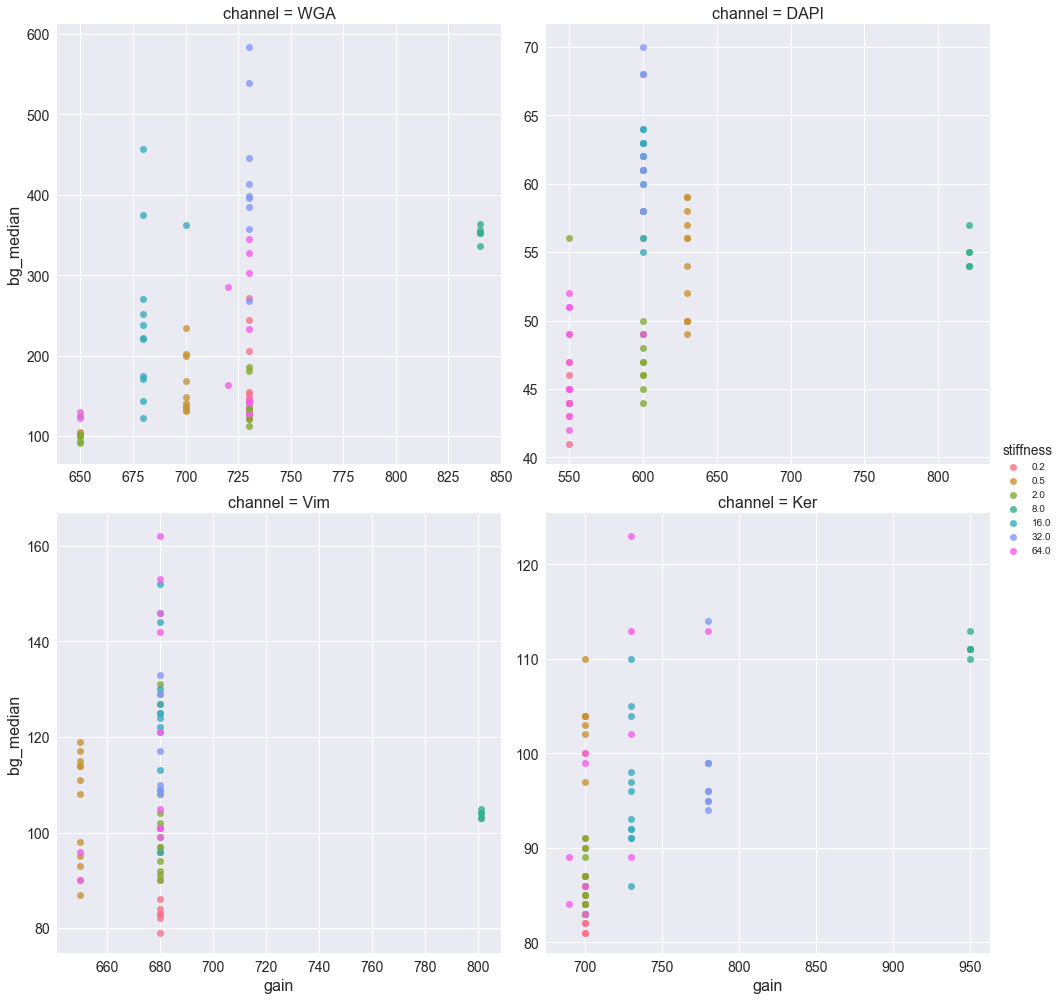

In [5]:
sns.lmplot(x='gain', y='bg_median', data=df, 
           col='channel', hue='stiffness', 
           sharex=False, sharey=False, 
           col_wrap=2, height=7, fit_reg=False);

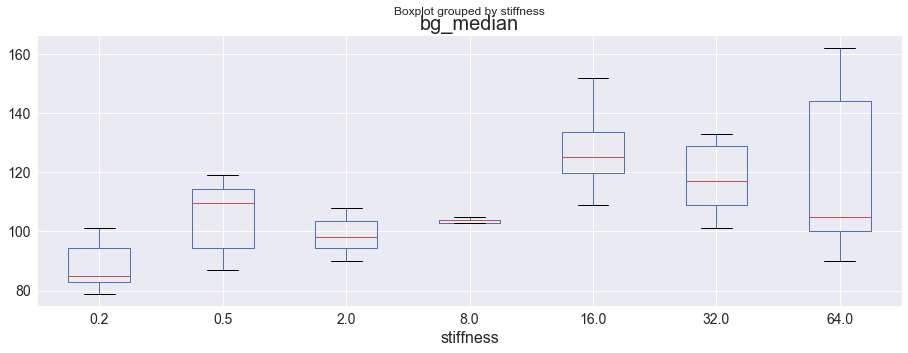

In [6]:
df.loc[df.channel == 'Vim'].boxplot(by='stiffness', column='bg_median', showfliers=False);

# Normalise images

In [7]:
# Load one image at a time
# Create image label
# Find corresponding bg_median in df dataframe
# Divide every pixel by this value
# Convert to unsigned int ??
# Save image as tiff without any transformations

# coeff2 = dict(df.groupby('channel').bg_median.max())
# multiplier = dict(df.groupby('channel').bg_median.max() / df.groupby('channel').mmax.max() * 65535)
coeff2 = dict(df.groupby('channel').bg_median.min())

for s in ("0.2", "0.5", "2", "8", "16", "32", "64"):
    # Combination B
    c = 'B'
    s = str(float(s))
    
    # List of images in the folder
    image_path = os.path.join(TIFF_PATH, 'Cytosoft ' + s + ' kPa/Combination ' + c)
    os.chdir(image_path)
    filenames = glob.glob("*.tif")
    
    # Only the original images
    originals = [name for name in filenames if len(name) < 14]
    for original in originals:
        w, t, channel = original.split('.')[0].split('-')
        label = "-".join([s, c, w, t])
        coeff1 = df.loc[(df.label == label) & (df.channel == channel), 'bg_median'].values
        
        image = plt.imread(original)
        
#         df.loc[(df.label == label) & (df.channel == channel), 'imin'] = image.min().min()
#         df.loc[(df.label == label) & (df.channel == channel), 'imax'] = image.max().max()
#         df.loc[(df.label == label) & (df.channel == channel), 'iunique'] = np.unique(image).shape[0]
        
        image_corr = image / coeff1
        
#         df.loc[(df.label == label) & (df.channel == channel), 'cmin'] = image_corr.min().min()
#         df.loc[(df.label == label) & (df.channel == channel), 'cmax'] = image_corr.max().max()
#         df.loc[(df.label == label) & (df.channel == channel), 'cunique'] = np.unique(image_corr).shape[0]
        
        image_corr = image_corr * coeff2[channel]        
#         df.loc[(df.label == label) & (df.channel == channel), 'mmin'] = image_corr.min().min()
#         df.loc[(df.label == label) & (df.channel == channel), 'mmax'] = image_corr.max().max()
#         df.loc[(df.label == label) & (df.channel == channel), 'munique'] = np.unique(image_corr).shape[0]
        
        
        image_corr = np.uint16(image_corr)
        im = Image.fromarray(image_corr)
        im.save("-".join([w, t, channel, "normbg"]) + ".tif")

In [ ]:
df.loc[df.channel == 'Vim'].boxplot(by='stiffness', column='imax', showfliers=False);

In [ ]:
df.loc[df.channel == 'Vim'].boxplot(by='stiffness', column='cmax', showfliers=False);

In [ ]:
df.loc[df.channel == 'Vim'].boxplot(by='stiffness', column='mmax', showfliers=False);

In [ ]:
df.groupby('channel').iunique.max(), df.groupby('channel').cunique.max(), df.groupby('channel').munique.max()

In [ ]:
100 - df.groupby('channel').munique.max() * 100 / df.groupby('channel').iunique.max()

In [ ]:
df.groupby('channel').mmax.max()

In [ ]:
df.groupby('channel').bg_median.max()

In [ ]:
df.groupby('channel').bg_median.min()

In [ ]:
df.groupby('channel').mmax.max() / 65535

In [ ]:
df.groupby('channel').bg_median.max() / df.groupby('channel').bg_median.min()

In [ ]:
df.groupby('channel').bg_median.max() / df.groupby('channel').mmax.max() * 65535

In [ ]:
# Save uint32 to .tif
im = Image.fromarray(image_corr)
im.save("-".join([w, t, channel, "tmp"]) + ".tif")